In [1]:
import pandas as pd
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Input,LSTM,Bidirectional,Embedding
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from PyEMD import EMD
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('^NSEI.csv')
# dataset.describe()
dataset = dataset.dropna()

In [3]:
series = np.array(dataset['Close']).reshape(-1,1)
output = np.squeeze(series)

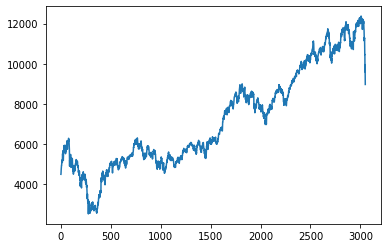

In [4]:
plt.plot(output)
plt.show()

In [5]:
N = len(series)
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(series)
data = np.squeeze(data)
data = data[:] + 2

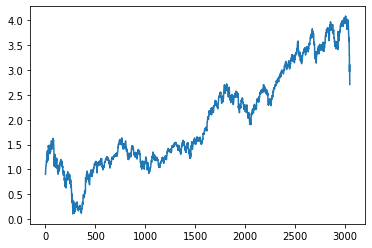

In [6]:
plt.plot(data)
plt.show()

In [7]:
emd = EMD()
imfs = emd.emd(data)
len(imfs)

8

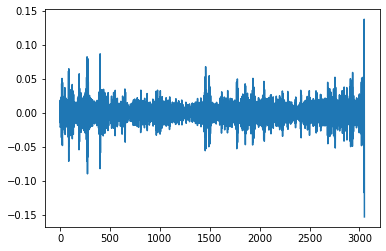

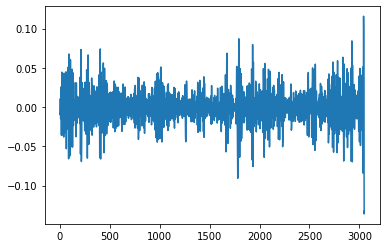

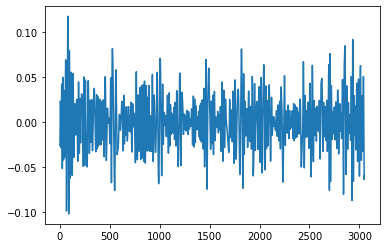

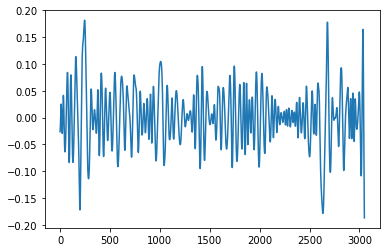

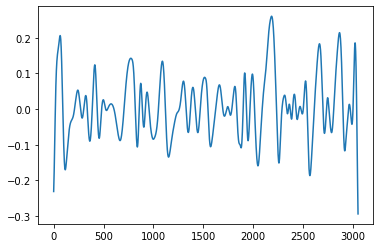

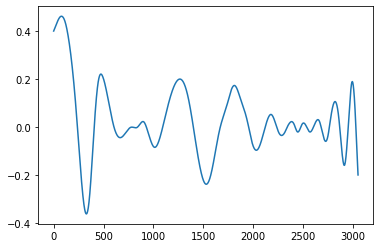

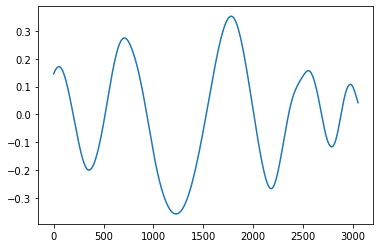

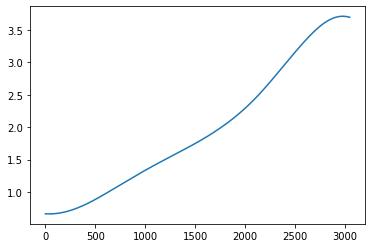

In [8]:
for i in range(len(imfs)):
    plt.plot(imfs[i])
    plt.show()

In [9]:
imfs.shape

(8, 3051)

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d_t' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d_t+%d' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
no_imfs_considered = imfs.shape[0]
x = np.zeros((imfs.shape[1],no_imfs_considered+1))
for i in range(imfs.shape[1]):
    for j in range(no_imfs_considered):
        x[i][j] = imfs[j][i]
    x[i][-1:] = data[i]
x.shape

(3051, 9)

In [12]:
pre_window=2
post_window=1
time_series_Data=series_to_supervised(x,pre_window,post_window)

starting_pt = (x.shape[1])*pre_window

del_cols = []
for i in range(starting_pt,len(time_series_Data.columns)-1):
    if (i+1)%(x.shape[1]) != 0:
        del_cols.append(i)
    
time_series_Data.drop(time_series_Data.columns[del_cols], axis=1, inplace=True)
time_series_Data.head(5)
# print(time_series_Data.shape)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var9_t
2,-0.020996,-0.008054,-0.025961,-0.026350,-0.231503,0.401482,0.145785,0.665577,0.899981,-0.020832,-0.009674,-0.015690,-0.025313,-0.222283,0.402446,0.146695,0.665484,0.920833,0.996128
3,-0.020832,-0.009674,-0.015690,-0.025313,-0.222283,0.402446,0.146695,0.665484,0.920833,0.018313,-0.001158,-0.003092,-0.022341,-0.212000,0.403423,0.147590,0.665393,0.996128,1.002276
4,0.018313,-0.001158,-0.003092,-0.022341,-0.212000,0.403423,0.147590,0.665393,0.996128,-0.015038,0.008248,0.009427,-0.017795,-0.200751,0.404411,0.148470,0.665304,1.002276,1.038680
5,-0.015038,0.008248,0.009427,-0.017795,-0.200751,0.404411,0.148470,0.665304,1.002276,-0.010276,0.010613,0.019047,-0.012034,-0.188635,0.405411,0.149335,0.665218,1.038680,1.076965
6,-0.010276,0.010613,0.019047,-0.012034,-0.188635,0.405411,0.149335,0.665218,1.038680,0.007506,0.005577,0.023309,-0.005419,-0.175748,0.406421,0.150185,0.665135,1.076965,1.079655


In [13]:
temp_x = []
temp_y = []
for index,rows in time_series_Data.iterrows():
    dummy_x = []
    dummy_y = []
    for i in range(starting_pt):
        dummy_x.append(np.asarray(rows[i]))
    for j in range(starting_pt,len(time_series_Data.columns)):
        dummy_y.append(np.asarray(rows[j]))
    temp_x.append(dummy_x)
    temp_y.append(dummy_y)
temp_x = np.asarray(temp_x)
temp_y = np.asarray(temp_y)

In [14]:
X = temp_x.reshape(temp_x.shape[0],1,temp_x.shape[1])
# Y = temp_y.reshape(temp_y.shape[0],1,temp_y.shape[1])
Y = temp_y
X.shape,Y.shape

((3049, 1, 18), (3049, 1))

In [15]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
from keras.layers import concatenate, dot, add, Activation, multiply, Lambda, Flatten, Reshape
def attention_layer(hidden_state, cell_state, x_input):
    concat_states = concatenate([hidden_state, cell_state])
    concat_states = Reshape((1, int(concat_states.shape[1])))(concat_states)
    part_1 = Dense(int(x_input.shape[2]),use_bias=False)(concat_states)
    part_2 = Dense(int(x_input.shape[2]),use_bias=False)(x_input)
    res = add([part_1, part_2])
    alpha = Activation('tanh')(res)
    beta = Activation('softmax')(alpha)
    final = multiply([beta,x_input])
    return final

In [26]:
model = Model()
input_layer = Input((X.shape[1], X.shape[2]))
# mid= LSTM(50, return_sequences=True)(input_layer)
mid, state_h, state_c = LSTM(int(input_layer.shape[2]), return_state=True, return_sequences=True)(input_layer)
# print(mid.shape)
res_at = attention_layer(state_h, state_c, input_layer)
lstm_2 = LSTM(50)(res_at)
output_layer = Dense(Y.shape[1], activation='linear')(lstm_2)
model = Model(input_layer,output_layer)
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(test_x, test_y))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 18)        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 1, 18), (Non 2664        input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 36)           0           lstm_3[0][1]                     
                                                                 lstm_3[0][2]                     
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, 36)        0           concatenate_2[0][0]        

2439/2439 [==============================] - 0s 58us/step - loss: 9.0744e-04 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 34/100
2439/2439 [==============================] - 0s 59us/step - loss: 8.7949e-04 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 35/100
2439/2439 [==============================] - 0s 58us/step - loss: 8.8985e-04 - accuracy: 0.0000e+00 - val_loss: 9.5732e-04 - val_accuracy: 0.0000e+00
Epoch 36/100
2439/2439 [==============================] - 0s 57us/step - loss: 8.3003e-04 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 37/100
2439/2439 [==============================] - 0s 58us/step - loss: 8.0836e-04 - accuracy: 0.0000e+00 - val_loss: 9.0742e-04 - val_accuracy: 0.0000e+00
Epoch 38/100
2439/2439 [==============================] - 0s 59us/step - loss: 8.0306e-04 - accuracy: 0.0000e+00 - val_loss: 8.8749e-04 - val_accuracy: 0.0000e+00
Epoch 39/100
2439/2439 [=======================

2439/2439 [==============================] - 0s 58us/step - loss: 5.0985e-04 - accuracy: 0.0000e+00 - val_loss: 5.2228e-04 - val_accuracy: 0.0000e+00
Epoch 84/100
2439/2439 [==============================] - 0s 59us/step - loss: 5.0661e-04 - accuracy: 0.0000e+00 - val_loss: 5.1703e-04 - val_accuracy: 0.0000e+00
Epoch 85/100
2439/2439 [==============================] - 0s 58us/step - loss: 4.7803e-04 - accuracy: 0.0000e+00 - val_loss: 5.7210e-04 - val_accuracy: 0.0000e+00
Epoch 86/100
2439/2439 [==============================] - 0s 58us/step - loss: 4.7534e-04 - accuracy: 0.0000e+00 - val_loss: 4.9613e-04 - val_accuracy: 0.0000e+00
Epoch 87/100
2439/2439 [==============================] - 0s 58us/step - loss: 4.5955e-04 - accuracy: 0.0000e+00 - val_loss: 4.9766e-04 - val_accuracy: 0.0000e+00
Epoch 88/100
2439/2439 [==============================] - 0s 59us/step - loss: 4.9172e-04 - accuracy: 0.0000e+00 - val_loss: 4.8299e-04 - val_accuracy: 0.0000e+00
Epoch 89/100
2439/2439 [===========

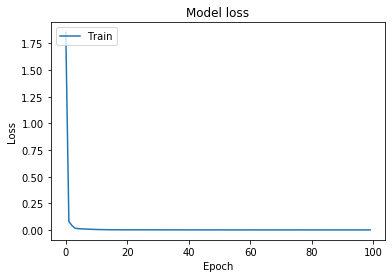

In [18]:
# plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
X_ann = temp_x.reshape(temp_x.shape[0],temp_x.shape[1])
Y_ann = temp_y
train_x_ann, test_x_ann, train_y_ann, test_y_ann = train_test_split(X_ann, Y_ann, test_size=0.2, random_state=42)

model_ann = Model()
input_layer = Input((X_ann.shape[1],))
mid = Dense(50)(input_layer)
output_layer = Dense(Y_ann.shape[1], activation='linear')(mid)
model_ann = Model(input_layer,output_layer)
model_ann.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
model_ann.summary()
history_ann = model_ann.fit(train_x_ann, train_y_ann, epochs=100, batch_size=32, validation_data=(test_x_ann, test_y_ann))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 18)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                950       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Train on 2439 samples, validate on 610 samples
Epoch 1/100
2439/2439 [==============================] - 0s 74us/step - loss: 0.5583 - accuracy: 0.0000e+00 - val_loss: 0.0137 - val_accuracy: 0.0000e+00
Epoch 2/100
2439/2439 [==============================] - 0s 21us/step - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 3/100
2439/2439 [=========

2439/2439 [==============================] - 0s 20us/step - loss: 4.9059e-04 - accuracy: 0.0000e+00 - val_loss: 5.0721e-04 - val_accuracy: 0.0000e+00
Epoch 47/100
2439/2439 [==============================] - 0s 20us/step - loss: 4.9017e-04 - accuracy: 0.0000e+00 - val_loss: 4.9682e-04 - val_accuracy: 0.0000e+00
Epoch 48/100
2439/2439 [==============================] - 0s 20us/step - loss: 4.9568e-04 - accuracy: 0.0000e+00 - val_loss: 5.2699e-04 - val_accuracy: 0.0000e+00
Epoch 49/100
2439/2439 [==============================] - 0s 20us/step - loss: 5.0208e-04 - accuracy: 0.0000e+00 - val_loss: 5.1876e-04 - val_accuracy: 0.0000e+00
Epoch 50/100
2439/2439 [==============================] - 0s 20us/step - loss: 4.9172e-04 - accuracy: 0.0000e+00 - val_loss: 5.0924e-04 - val_accuracy: 0.0000e+00
Epoch 51/100
2439/2439 [==============================] - 0s 21us/step - loss: 4.8618e-04 - accuracy: 0.0000e+00 - val_loss: 5.3048e-04 - val_accuracy: 0.0000e+00
Epoch 52/100
2439/2439 [===========

2439/2439 [==============================] - 0s 19us/step - loss: 4.9860e-04 - accuracy: 0.0000e+00 - val_loss: 4.0947e-04 - val_accuracy: 0.0000e+00
Epoch 97/100
2439/2439 [==============================] - 0s 22us/step - loss: 5.0000e-04 - accuracy: 0.0000e+00 - val_loss: 5.1551e-04 - val_accuracy: 0.0000e+00
Epoch 98/100
2439/2439 [==============================] - 0s 20us/step - loss: 4.9094e-04 - accuracy: 0.0000e+00 - val_loss: 4.2635e-04 - val_accuracy: 0.0000e+00
Epoch 99/100
2439/2439 [==============================] - 0s 20us/step - loss: 4.8789e-04 - accuracy: 0.0000e+00 - val_loss: 4.1289e-04 - val_accuracy: 0.0000e+00
Epoch 100/100
2439/2439 [==============================] - 0s 20us/step - loss: 4.6618e-04 - accuracy: 0.0000e+00 - val_loss: 4.9816e-04 - val_accuracy: 0.0000e+00


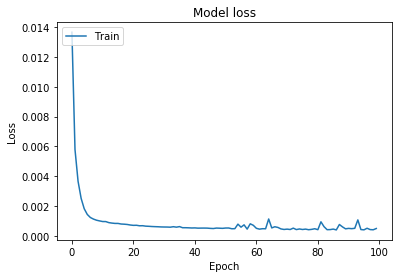

In [20]:
# plt.plot(history_ann.history['loss'])
plt.plot(history_ann.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
predicted = []
predicted_ann = []
gt = []

for i in range(50):
    inp = np.asarray([X[i]])
    result = model.predict(inp)
    result_ann = model_ann.predict(X[i])
    actual = Y[i]
#     print(result, actual)
    predicted.append(result[0][0])
    predicted_ann.append(result_ann[0][0])
    gt.append(actual[0])

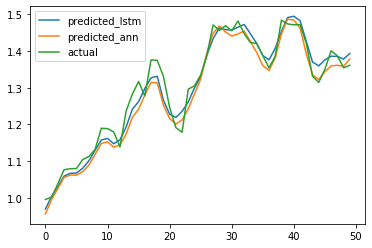

In [22]:
plt.plot(predicted,label='predicted_lstm')
plt.plot(predicted_ann,label='predicted_ann')
plt.plot(gt,label='actual')
plt.legend()

In [23]:
# def data_prep(temp_data, no_imfs):
#     signal = []
#     for i in range(len(temp_data)):
#         signal.append(temp_data[i])
#     signal = np.asarray(signal)
#     imfs = emd.emd(signal)

#     x = np.zeros((1,no_imfs+1))
#     for i in range(x.shape[0]):
#         for j in range(no_imfs):
#             if j<len(imfs):
#                 x[i][j] = imfs[j][-1]
#             else:
#                 x[i][j] = imfs[-1][-1]
#         x[i][-1] = signal[-1]
#     return np.asarray([x])

In [24]:
# total_samples = 1500
# sample = list(data[:total_samples])
# finals = []
# exp = []
# for i in range(100):
#     test_inp = data_prep(sample,no_imfs_considered)
#     test_res = model.predict(test_inp)

#     sample = sample[1:total_samples]
#     sample.append(test_res[0][0])
#     finals.append(test_res[0][0])
#     exp.append(data[total_samples+i])
# plt.plot(finals)
# plt.plot(exp)
# plt.show()